In [1]:
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from math import sqrt
from utils import get_test_table
import pandas as pd
from sklearn.model_selection import ParameterGrid

In [2]:
dataset = pd.read_csv('data_temp/100_gauge.csv', index_col=False)

In [3]:
dataset['Date'] = pd.to_datetime(dataset['Timestamp'], unit='s')
dataset = dataset.drop(['Timestamp'], axis=1)

In [4]:
split_index = int(0.7 * len(dataset))
X = dataset.drop(['prec'], axis=1)
y = dataset['prec']
X_train, X_test, y_train, y_test = X.iloc[:split_index], X.iloc[split_index:], y.iloc[:split_index], y.iloc[split_index:]

In [5]:
param_grid = {
    'changepoint_prior_scale': [0.001, 0.1],
    'seasonality_prior_scale': [0.01, 1.0]
}

grid = ParameterGrid(param_grid)

In [7]:
train_df = pd.concat([X_train[['Date']], y_train], axis=1)
train_df = train_df.rename(columns={'Date': 'ds', 'prec': 'y'})

additional_regressors = ['surf_net_therm_rad_max', '10m_wind_u', 'surf_net_therm_rad_mean']

train_df = pd.concat([train_df, X_train[additional_regressors]], axis=1)


In [9]:
results = []

for params in grid:
    model = Prophet(
        changepoint_prior_scale=params['changepoint_prior_scale'],
        seasonality_prior_scale=params['seasonality_prior_scale']
    )
    
    for regressor in additional_regressors:
        model.add_regressor(regressor)

    model.fit(train_df)

    future_df = pd.concat([X_test[['Date']].rename(columns={'Date': 'ds'}), X_test[additional_regressors]], axis=1)

    forecast = model.predict(future_df)
    #Saying that min is 0
    forecast['yhat'] = forecast['yhat'].clip(lower=0)

    y_pred = forecast['yhat'].values
    rmse = sqrt(mean_squared_error(y_test.values, y_pred))

    results.append({'params': params, 'rmse': rmse})

    print(f"Parameters: {params}, RMSE: {rmse:.4f}")

best_params = sorted(results, key=lambda x: x['rmse'])[0]
print(f'\nBest Parameters: {best_params}')

17:41:35 - cmdstanpy - INFO - Chain [1] start processing
17:43:52 - cmdstanpy - INFO - Chain [1] done processing


Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01}, RMSE: 5.3860


17:47:49 - cmdstanpy - INFO - Chain [1] start processing
17:50:13 - cmdstanpy - INFO - Chain [1] done processing


Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0}, RMSE: 5.3882


17:54:02 - cmdstanpy - INFO - Chain [1] start processing
17:58:58 - cmdstanpy - INFO - Chain [1] done processing


Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01}, RMSE: 5.3746


18:02:37 - cmdstanpy - INFO - Chain [1] start processing
18:06:51 - cmdstanpy - INFO - Chain [1] done processing


Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0}, RMSE: 5.3744

Best Parameters: {'params': {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0}, 'rmse': 5.37436218520368}


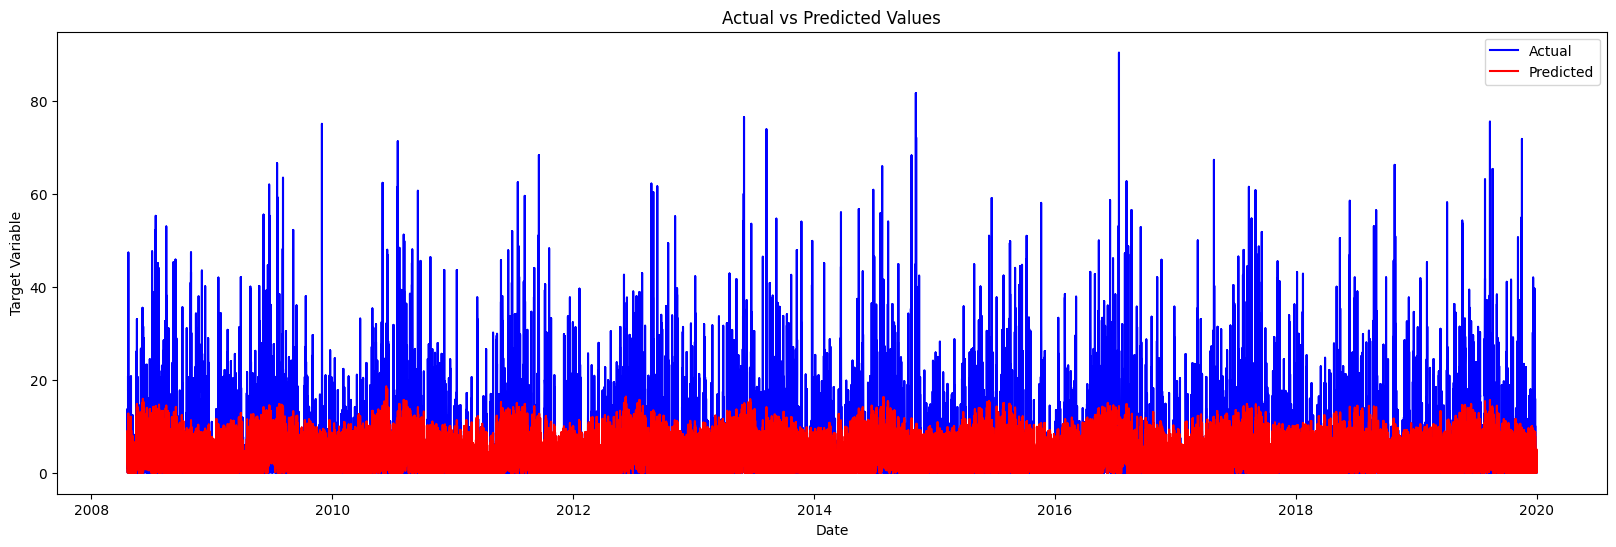

In [14]:
import matplotlib.pyplot as plt

dates = X_test['Date']

plt.figure(figsize=(20, 6))
plt.plot(dates, y_test.values, label='Actual', color='blue')

plt.plot(dates, forecast['yhat'].values, label='Predicted', color='red')

plt.title('Actual vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Target Variable')

plt.legend()
plt.show()


In [ ]:
dates = X_test['Date']

plt.figure(figsize=(10, 6))
plt.plot(dates, y_test.values, label='Actual', color='blue')

plt.plot(dates, forecast['yhat'].values, label='Predicted', color='red')

plt.title('Actual vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Target Variable')

plt.legend() 
plt.show()